In [1]:
import pandas as pd
import radon
import matplotlib.pyplot as plt
import code_bert_score
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze
import ast
import gc
import cuda
import torch
import sacrebleu

In [2]:
df = pd.read_csv("rectified_sample_df.csv")
print(df.columns)

Index(['hash', 'date', 'original_message', 'file_name', 'prev_source_code',
       'cur_source_code', 'diff', 'llm_commit_inference', 'rectified_message',
       'og_score', 'llm_score', 'rectified_score'],
      dtype='object')


In [3]:
print("Total number of files:", df['file_name'].nunique())
print("Total number of commits:", df['hash'].nunique())

Total number of files: 132
Total number of commits: 106


In [4]:
print(f"Average number of files modified per commit: {df.groupby('hash')['file_name'].nunique().mean()}")

Average number of files modified per commit: 1.8679245283018868


In [5]:
llm_inferences = df["llm_commit_inference"].to_list()
prefixes = [llm_inferences[i].split()[0] for i in range(len(llm_inferences))]
print(prefixes)

['update', 'fix', 'update', 'update', 'update', 'update', 'add', 'fix', 'fix', 'add', 'fix', 'create', 'fix', 'fix', 'update', 'simplify', 'add', 'add', 'improve', 'add', 'add', 'add', 'use', 'add', 'add', 'fix', 'add', 'update', 'update', 'add', 'update', 'fix', 'fix', 'add', 'improve', 'update', 'add', 'update', 'add', 'add', 'fix', 'fix', 'use', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'add', 'update', 'add', 'add', 'fix', 'fix', 'add', 'update', 'add', 'update', 'update', 'add', 'add', 'add', 'fix', 'create', 'remove', 'add', 'fix', 'add', 'set', 'add', 'update', 'update', 'add', 'update', 'update', 'use', 'add', 'add', 'fix', 'fix', 'set', 'fix', 'update', 'add', 'add', 'fix', 'update', 'add', 'add', 'update', 'fix', 'fix', 'update', 'add', 'add', 'add', 'add', 'update', 'add', 'add', 'add', 'add', 'add', 'add', 'add', 'fix', 'add', 'fix', 'fix', 'fix', 'update', 'fix', 'add', 'use', 'add', 'update', 'update', 'use', 'remove', 'add', 'update', 'update'

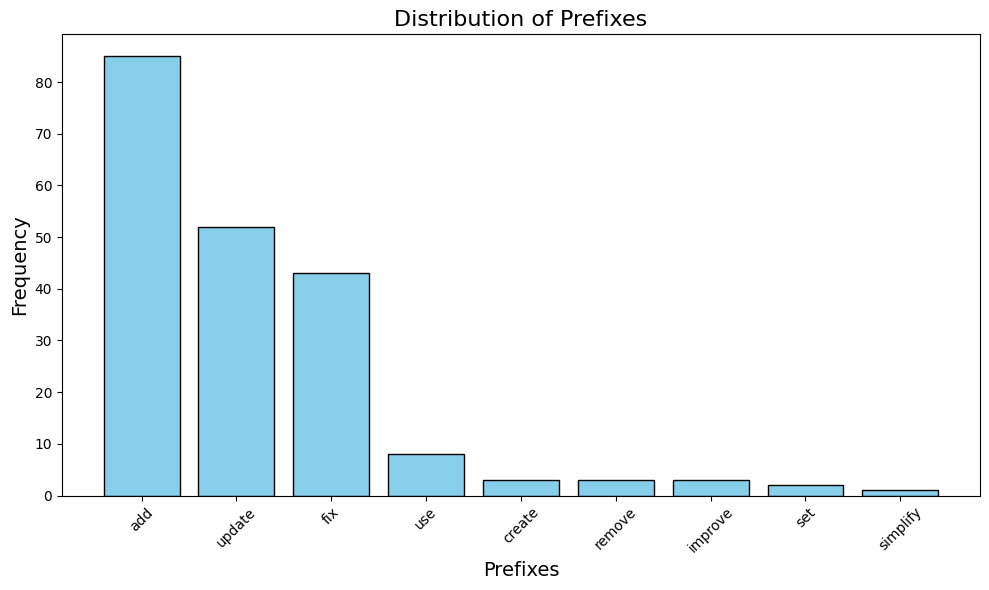

In [6]:
plt.figure(figsize=(10, 6))
counts = pd.Series(prefixes).value_counts()
bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Prefixes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Prefixes', fontsize=16)
plt.xticks(rotation=45, ha='center')
plt.tight_layout()
plt.show()

In [7]:
extensions = [f".{ext.split('.')[-1]}" for ext in df["file_name"].to_list()]
filenames = [f"{ext.split('.')[0]}" for ext in df["file_name"].to_list()]

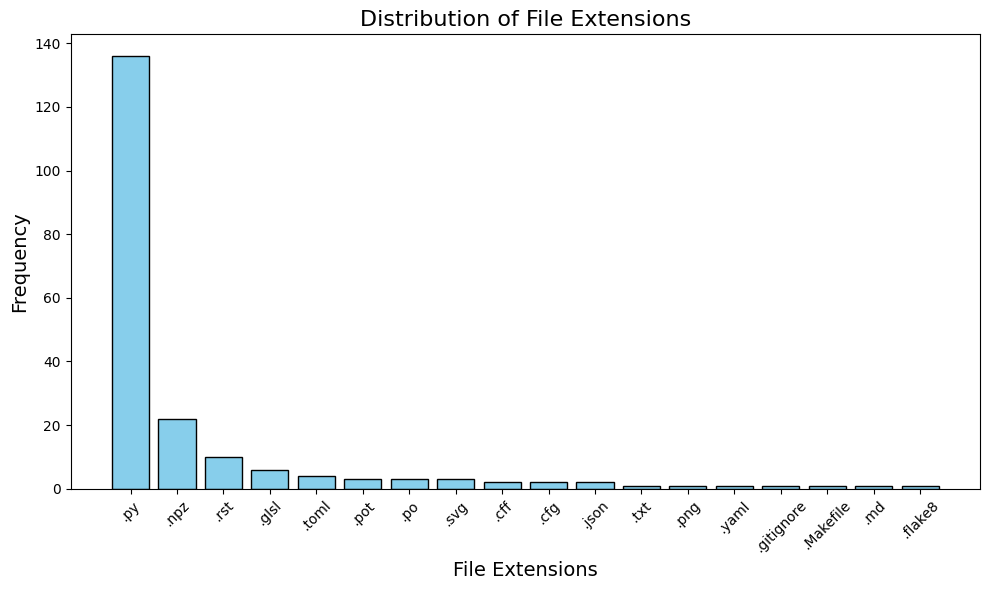

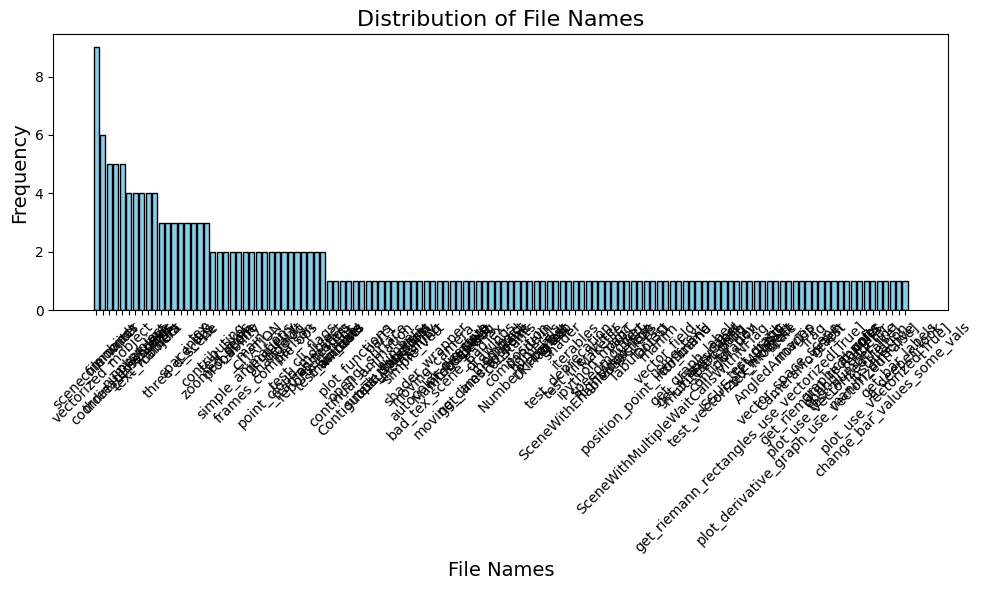

In [8]:
plt.figure(figsize=(10, 6))
counts = pd.Series(extensions).value_counts()
bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.xlabel('File Extensions', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of File Extensions', fontsize=16)
plt.xticks(rotation=45, ha='center')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
counts = pd.Series(filenames).value_counts()
bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.xlabel('File Names', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of File Names', fontsize=16)
plt.xticks(rotation=45, ha='center')
plt.tight_layout()
plt.show()


In [9]:
df = df.dropna().reset_index(drop=True)
df = df[df["file_name"].str.endswith('.py')].reset_index(drop=True)
print(len(df))

126


In [10]:
for i, row in df.iterrows():
    prev_code = df.at[i, "prev_source_code"] = df.loc[i, "prev_source_code"][2:-1].encode().decode('unicode_escape')
    cur_code = df.at[i, "cur_source_code"] = df.loc[i, "cur_source_code"][2:-1].encode().decode('unicode_escape')
    try:
        prev_visit = cc_visit(prev_code)
    except Exception as e:
        print(f"Error processing row {i}: {e}")
        continue
    try:
        cur_visit = cc_visit(cur_code)
    except Exception as e:
        print(f"Error processing row {i}: {e}")
        continue
    prev_complexity = sum(node.complexity for node in prev_visit)
    cur_complexity = sum(node.complexity for node in cur_visit)
    df.at[i, 'CC_Change'] = cur_complexity - prev_complexity
    try:
        mi_before = mi_visit(prev_code, multi=False)
    except Exception as e:
        print(f"Error processing row {i}: {e}")
        continue
    try:
        mi_after = mi_visit(cur_code, multi=False)
    except Exception as e:
        print(f"Error processing row {i}: {e}")
        continue
    df.at[i, 'MI_Change'] = mi_after - mi_before
    loc_before = analyze(prev_code).loc
    loc_after = analyze(cur_code).loc
    df.at[i, 'LOC_Change'] = loc_after - loc_before


<unknown>:462: SyntaxWarning: invalid escape sequence '\o'
<unknown>:463: SyntaxWarning: invalid escape sequence '\o'
<unknown>:463: SyntaxWarning: invalid escape sequence '\o'
<unknown>:463: SyntaxWarning: invalid escape sequence '\o'
<unknown>:463: SyntaxWarning: invalid escape sequence '\o'
<unknown>:539: SyntaxWarning: invalid escape sequence '\p'


Error processing row 9: Missing parentheses in call to 'print'. Did you mean print(...)? (<unknown>, line 1170)
Error processing row 25: Invalid star expression (<unknown>, line 372)
Error processing row 33: Invalid star expression (<unknown>, line 183)
Error processing row 39: Invalid star expression (<unknown>, line 912)
Error processing row 52: invalid syntax (<unknown>, line 133)
Error processing row 66: SyntaxError at line: 8
Error processing row 71: Lambda expression parameters cannot be parenthesized (<unknown>, line 217)
Error processing row 77: Lambda expression parameters cannot be parenthesized (<unknown>, line 203)


<unknown>:1364: SyntaxWarning: invalid escape sequence '\s'
<unknown>:1406: SyntaxWarning: invalid escape sequence '\s'
<unknown>:1364: SyntaxWarning: invalid escape sequence '\s'
<unknown>:1406: SyntaxWarning: invalid escape sequence '\s'
<unknown>:1364: SyntaxWarning: invalid escape sequence '\s'
<unknown>:1406: SyntaxWarning: invalid escape sequence '\s'
<unknown>:1364: SyntaxWarning: invalid escape sequence '\s'
<unknown>:1406: SyntaxWarning: invalid escape sequence '\s'


Error processing row 121: Lambda expression parameters cannot be parenthesized (<unknown>, line 216)


In [11]:
df = df.dropna().reset_index(drop = True)

In [12]:
print(len(df))

117


In [13]:
def semantic_similarity(codelist1, codelist2):
    P, R, F1, F3 = code_bert_score.score(codelist1, codelist2, lang = "python", verbose = True, rescale_with_baseline=True, device = "cuda")
    return F1

In [14]:
prev_list = df["prev_source_code"].to_list()
cur_list = df["cur_source_code"].to_list()
for i in range(len(prev_list)):
  gc.collect()
  torch.cuda.empty_cache()
  df.at[i, "semantic_similarity"] = semantic_similarity([prev_list[i]], [cur_list[i]]).item()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.26 seconds, 0.31 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 10.79 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.44 seconds, 2.30 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.42 seconds, 2.40 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.54 seconds, 0.28 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.90 seconds, 1.11 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.43 seconds, 2.35 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.69 seconds, 0.59 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.73 seconds, 0.37 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.87 seconds, 0.53 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.08 seconds, 0.92 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.65 seconds, 1.54 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.25 seconds, 3.95 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 5.63 seconds, 0.18 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.58 seconds, 0.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.61 seconds, 0.38 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.85 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.79 seconds, 0.36 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.92 seconds, 0.34 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.25 seconds, 3.97 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.95 seconds, 1.05 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.71 seconds, 1.42 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.25 seconds, 0.80 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 3.17 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 11.49 seconds, 0.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.91 seconds, 1.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.74 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.36 seconds, 0.74 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.62 seconds, 0.62 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.79 seconds, 1.26 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.16 seconds, 0.87 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.42 seconds, 2.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.11 seconds, 0.47 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 18.49 seconds, 0.05 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.56 seconds, 0.64 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.38 seconds, 2.66 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.92 seconds, 0.52 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 6.39 seconds, 0.16 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.33 seconds, 0.75 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.44 seconds, 2.29 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.77 seconds, 1.29 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.59 seconds, 1.70 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.37 seconds, 2.70 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.96 seconds, 0.51 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.24 seconds, 0.24 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.91 seconds, 0.52 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 6.47 seconds, 0.15 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.47 seconds, 2.11 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.92 seconds, 1.08 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.82 seconds, 0.55 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.92 seconds, 0.52 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.55 seconds, 1.81 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.23 seconds, 0.81 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.31 seconds, 0.76 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.44 seconds, 0.70 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.30 seconds, 3.37 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.10 seconds, 0.91 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.93 seconds, 0.34 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.15 seconds, 0.47 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.03 seconds, 0.97 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 6.71 seconds, 0.15 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.75 seconds, 1.33 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 8.23 seconds, 0.12 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 6.24 seconds, 0.16 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.26 seconds, 0.44 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.74 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 9.91 seconds, 0.10 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.38 seconds, 0.72 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.64 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.70 seconds, 1.42 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 6.19 seconds, 0.16 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.20 seconds, 0.45 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.06 seconds, 0.48 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.54 seconds, 1.87 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.65 seconds, 0.61 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.65 seconds, 1.53 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.82 seconds, 1.22 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 11.74 seconds, 0.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 10.58 seconds, 0.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.87 seconds, 0.53 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.53 seconds, 1.90 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.91 seconds, 1.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.57 seconds, 1.76 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.69 seconds, 0.37 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.42 seconds, 2.41 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.99 seconds, 0.50 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.31 seconds, 3.21 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.69 seconds, 0.27 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.24 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.47 seconds, 2.15 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.37 seconds, 2.73 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.87 seconds, 0.54 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.96 seconds, 0.34 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.53 seconds, 1.90 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.61 seconds, 0.22 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.74 seconds, 0.27 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.32 seconds, 0.43 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 4.24 seconds, 0.24 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 3.24 seconds, 0.31 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.22 seconds, 0.82 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.82 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 8.64 seconds, 0.12 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.65 seconds, 0.61 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.42 seconds, 2.39 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.91 seconds, 1.10 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.32 seconds, 3.13 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.61 seconds, 1.63 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 6.04 seconds, 0.17 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.04 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 8.66 seconds, 0.12 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.67 seconds, 0.60 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.95 seconds, 1.05 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 2.18 seconds, 0.46 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.91 seconds, 1.09 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.68 seconds, 1.48 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.32 seconds, 0.76 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.53 seconds, 0.65 sentences/sec


In [15]:
len(df)

117

Mean value: 0.9561958700163752


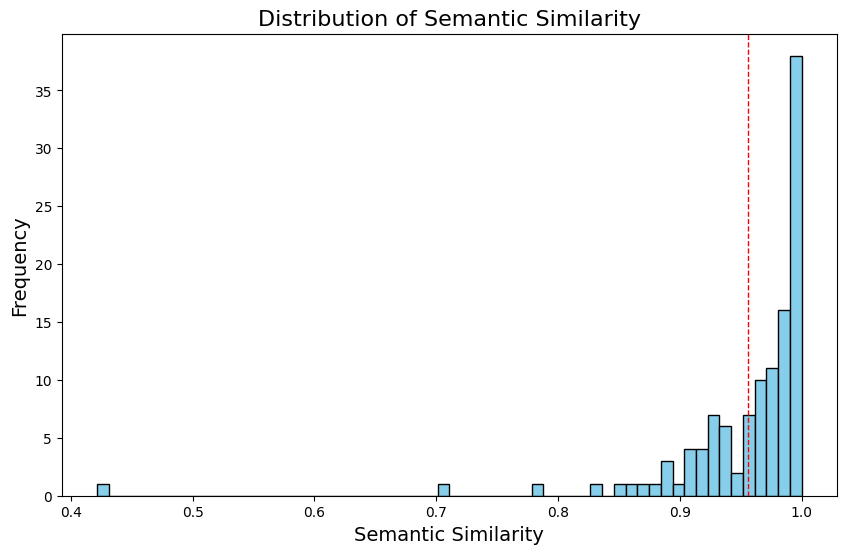

In [38]:
semantic_list = df["semantic_similarity"].to_list()
semantic_mean = sum(semantic_list) / len(semantic_list)
print("Mean value:", semantic_mean)
plt.figure(figsize=(10, 6))
plt.hist(semantic_list, bins=60, color='skyblue', edgecolor='black')
plt.axvline(x=semantic_mean, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Semantic Similarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Semantic Similarity', fontsize=16)
plt.show()

In [18]:
df2 = df.dropna().reset_index(drop = True)

In [19]:
len(df2), len(df)

(117, 117)

In [20]:
type(df.loc[0, 'prev_source_code'])

str

In [25]:
for i, row in df.iterrows():
    prev_code = df.loc[i, 'prev_source_code']
    cur_code = df.loc[i, 'cur_source_code']
    df.at[i, 'Token_Similarity'] = sacrebleu.corpus_bleu([prev_code], [[cur_code]]).score / 100

Mean value: 0.936974549542415


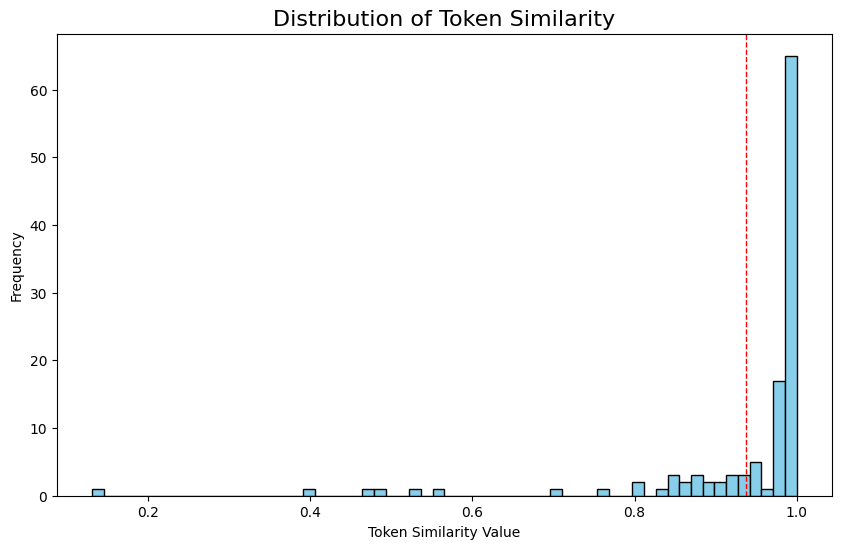

In [43]:
token_list = df["Token_Similarity"].to_list()
token_mean = sum(token_list) / len(token_list)
print("Mean value:", token_mean)
plt.figure(figsize=(10, 6))
plt.hist(token_list, bins=60, color='skyblue', edgecolor='black')
plt.xlabel("Token Similarity Value")
# Make a vertical line at x = token_mean
plt.axvline(x=token_mean, color='red', linestyle='dashed', linewidth=1)
plt.ylabel("Frequency")
plt.title('Distribution of Token Similarity', fontsize=16)
plt.show()

In [ ]:
for i, row in df.iterrows():
    df.at[i, "semantic_class"] = "Major" if df.loc[i, "semantic_similarity"] < semantic_mean else "Minor"
    df.at[i, "token_class"] = "Major" if df.loc[i, "Token_Similarity"] < token_mean else "Minor"
    if df.loc[i, "semantic_class"] == df.loc[i, "token_class"]:
        df.at[i, "Classes_Agree"] = "YES"
    else:
        df.at[i, "Classes_Agree"] = "NO"


In [47]:
print(len(df[df["semantic_class"] == "Major"]))
print(len(df[df["semantic_class"] == "Minor"]))

79
38


In [48]:
print(len(df[df["token_class"] == "Major"]))
print(len(df[df["token_class"] == "Minor"]))

89
28


In [51]:
df.to_csv("final_df.csv")